In [1]:
!pip install scikit-fuzzy pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Baca dataset
df = pd.read_csv('credit_risk_dataset.csv')
df.head()


,Income,Debt,PaymentHistory
0,6.87,7.84,4.3
1,14.36,5.80,6.7
2,11.52,3.31,6.7
3,9.78,1.04,5.8
4,4.03,3.14,1.8


In [9]:
x_income = np.arange(0, 16, 0.1)
x_debt = np.arange(0, 10, 0.1)
x_history = np.arange(0, 11, 0.1)
x_risk = np.arange(0, 11, 0.1)

In [10]:
income_low = fuzz.trimf(x_income, [0, 0, 4])
income_med = fuzz.trimf(x_income, [3, 7, 11])
income_high = fuzz.trimf(x_income, [8, 15, 15])

debt_low = fuzz.trimf(x_debt, [0, 0, 2])
debt_med = fuzz.trimf(x_debt, [1.5, 5, 7])
debt_high = fuzz.trimf(x_debt, [6, 9, 9])

history_bad = fuzz.trimf(x_history, [0, 0, 4])
history_avg = fuzz.trimf(x_history, [3, 6, 8])
history_good = fuzz.trimf(x_history, [7, 10, 10])

risk_low = fuzz.trimf(x_risk, [0, 0, 5])
risk_med = fuzz.trimf(x_risk, [3, 6, 8])
risk_high = fuzz.trimf(x_risk, [6, 10, 10])


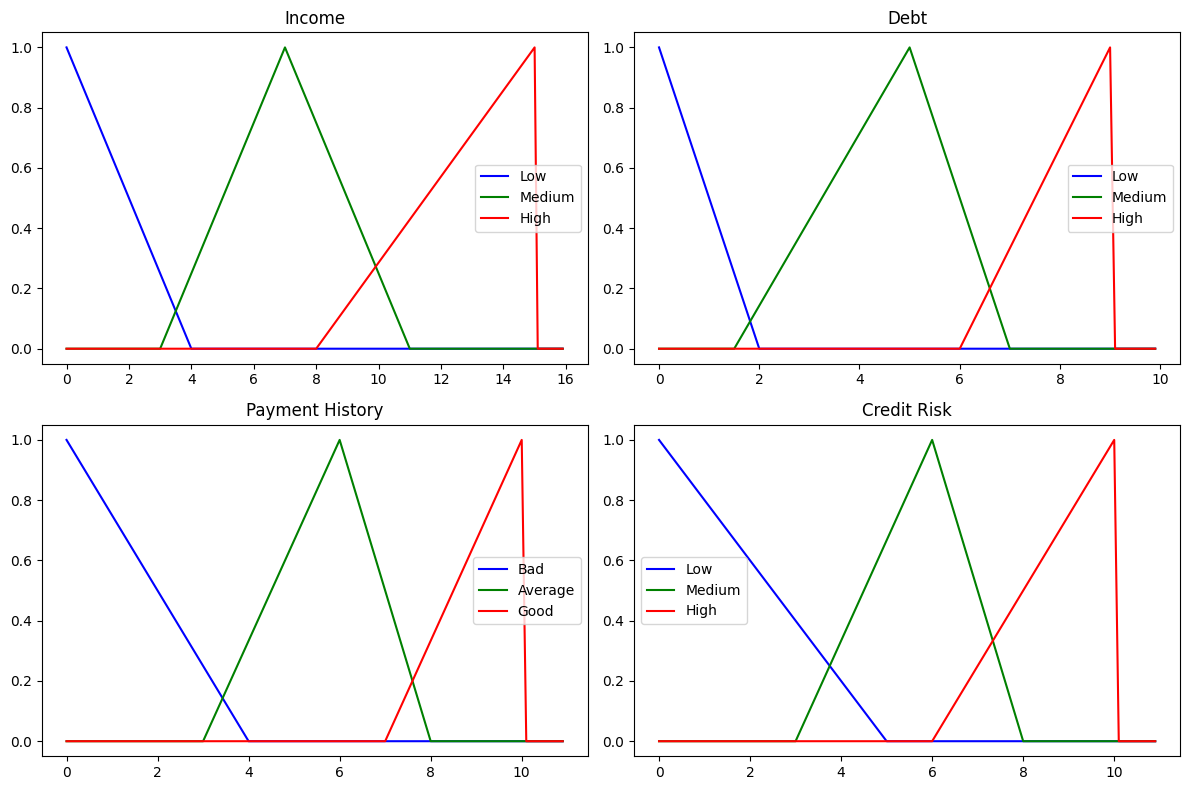

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(x_income, income_low, 'b', label='Low')
plt.plot(x_income, income_med, 'g', label='Medium')
plt.plot(x_income, income_high, 'r', label='High')
plt.title('Income')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x_debt, debt_low, 'b', label='Low')
plt.plot(x_debt, debt_med, 'g', label='Medium')
plt.plot(x_debt, debt_high, 'r', label='High')
plt.title('Debt')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x_history, history_bad, 'b', label='Bad')
plt.plot(x_history, history_avg, 'g', label='Average')
plt.plot(x_history, history_good, 'r', label='Good')
plt.title('Payment History')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x_risk, risk_low, 'b', label='Low')
plt.plot(x_risk, risk_med, 'g', label='Medium')
plt.plot(x_risk, risk_high, 'r', label='High')
plt.title('Credit Risk')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
def fuzzy_credit_risk(income, debt, history):
    # Derajat keanggotaan input
    income_level_low = fuzz.interp_membership(x_income, income_low, income)
    income_level_med = fuzz.interp_membership(x_income, income_med, income)
    income_level_high = fuzz.interp_membership(x_income, income_high, income)

    debt_level_low = fuzz.interp_membership(x_debt, debt_low, debt)
    debt_level_med = fuzz.interp_membership(x_debt, debt_med, debt)
    debt_level_high = fuzz.interp_membership(x_debt, debt_high, debt)

    history_level_bad = fuzz.interp_membership(x_history, history_bad, history)
    history_level_avg = fuzz.interp_membership(x_history, history_avg, history)
    history_level_good = fuzz.interp_membership(x_history, history_good, history)

    # --- Aturan fuzzy (rules) ---
    rule1 = np.fmin(np.fmin(income_level_high, debt_level_low), history_level_good)   # Risk Low
    rule2 = np.fmin(np.fmin(income_level_low, debt_level_high), history_level_bad)    # Risk High
    rule3 = np.fmin(np.fmin(income_level_med, debt_level_med), history_level_avg)     # Risk Medium
    rule4 = np.fmin(income_level_low, history_level_good)                             # Risk Medium
    rule5 = np.fmin(income_level_high, history_level_bad)                             # Risk Medium

    # Aktivasi hasil
    activate_low = np.fmax(rule1, 0)
    activate_med = np.fmax(np.fmax(rule3, np.fmax(rule4, rule5)), 0)
    activate_high = np.fmax(rule2, 0)

    # Gabungkan semua hasil ke output
    aggregated = np.fmax(np.fmax(
        np.fmin(activate_low, risk_low),
        np.fmin(activate_med, risk_med)
    ), np.fmin(activate_high, risk_high))

    # Hindari error defuzz jika area kosong
    if aggregated.sum() == 0:
        return 5  # risiko sedang (default)

    # Defuzzifikasi (ambil nilai crisp)
    risk_value = fuzz.defuzz(x_risk, aggregated, 'centroid')
    return risk_value

In [14]:
df['PredictedRisk'] = df.apply(
    lambda row: fuzzy_credit_risk(row['Income'], row['Debt'], row['PaymentHistory']),
    axis=1
)

print("Data dengan kolom PredictedRisk:")
df.head(10)


Data dengan kolom PredictedRisk:


,Income,Debt,PaymentHistory,PredictedRisk
0,6.87,7.84,4.3,5.000000
1,14.36,5.80,6.7,5.000000
2,11.52,3.31,6.7,5.000000
3,9.78,1.04,5.8,5.000000
4,4.03,3.14,1.8,5.000000
5,4.03,3.26,8.5,5.000000
6,2.76,6.70,3.9,8.050000
7,13.26,5.92,2.7,5.575551
8,9.81,8.04,1.4,5.561335
9,11.20,4.51,6.3,5.000000


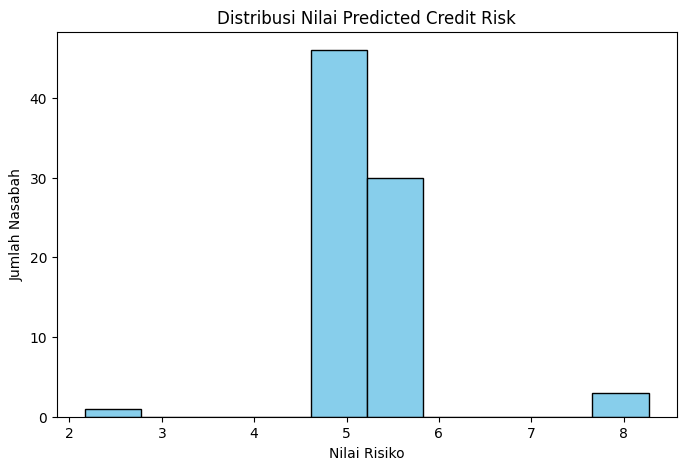

In [15]:
plt.figure(figsize=(8,5))
plt.hist(df['PredictedRisk'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribusi Nilai Predicted Credit Risk')
plt.xlabel('Nilai Risiko')
plt.ylabel('Jumlah Nasabah')
plt.show()

In [16]:
avg_risk = df['PredictedRisk'].mean()
print(f"Rata-rata nilai risiko kredit: {avg_risk:.2f}")

if avg_risk > 6:
    print("💡 Insight: Mayoritas nasabah berisiko tinggi, bank perlu memperketat penilaian kredit.")
elif avg_risk > 4:
    print("💡 Insight: Sebagian besar nasabah berada pada risiko sedang, kebijakan bisa dipertahankan.")
else:
    print("💡 Insight: Mayoritas nasabah berisiko rendah, potensi ekspansi kredit bisa ditingkatkan.")


Rata-rata nilai risiko kredit: 5.29
💡 Insight: Sebagian besar nasabah berada pada risiko sedang, kebijakan bisa dipertahankan.


In [18]:
df.to_csv("credit_risk_with_prediction.csv", index=False)
!pip freeze > requirements.txt
